<a href="https://colab.research.google.com/github/aryaagarwaal/ddls-course-2024/blob/main/MelanomaPrimary%26MetastaticWSI_(Modified).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Metastatic and Primary Melanoma Tumor Identification Using Whole Slide Images (WSI)
This project processes Whole Slide Images (WSI) of metastatic and primary melanoma tumor tissues to extract regions of interest (ROIs), train a Vision Transformer (ViT) model, and generate Grad-CAM visualizations to interpret model predictions.

**Table of Contents**

1. Installation
2. Import Required Libraries
3. Path Specifications
4. Processing and Downsample WSIs
5. ROI Extraction and Color Segmentation
6. Load and Split Data
7. Save Data
8. Vision Transformer (ViT) Model Creation
9. Evaluation and Metrics
10. Grad-CAM Visualization






**1. Installation**

To run this project, you'll need the following Python packages installed:

In [2]:
!pip install openslide-python
!apt-get install openslide-tools
!pip install Pillow


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
openslide-tools is already the newest version (3.4.1+dfsg-5build1).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.


Mount your Google Drive while using Google Colab:

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**2. Import Required Libraries**

Libraries for image processing, machine learning, and file management are imported.

In [3]:
import os
import openslide
import random
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from PIL import Image
Image.MAX_IMAGE_PIXELS = None  # Disable the limit completely
import cv2
from skimage import measure
import tensorflow.keras.backend as K
from skimage.measure import label, regionprops
import matplotlib.pyplot as plt

**3. Path Specifications**

Set paths for folders containing primary and metastatic WSI files and for saving output images and extracted ROIs.

In [4]:
#Path specification for Primary WSI
primary_folder = '/content/drive/MyDrive/Arya_Data/Primary TCGA-SKCM'
# Output folder where downsampled .svs files or regions of interest (ROI) will be saved
output_folder1 = '/content/drive/My Drive/Arya_Data/output_downsampled/primary'

# Create output folder if it doesn't exist
if not os.path.exists(output_folder1):
   os.makedirs(output_folder)

#Path specification for Metastatic WSI
metastatic_folder = '/content/drive/MyDrive/Arya_Data/Metastatic TCGA-SKCM'
output_folder2 = '/content/drive/My Drive/Arya_Data/output_downsampled/metastatic'

# Create output folder if it doesn't exist
if not os.path.exists(output_folder2):
   os.makedirs(output_folder)

**4. Process and Downsample WSI Files**

The process_svs_file function processes WSI files by downsampling them to a lower resolution to reduce memory usage. The processed images are saved in the specified folder.



In [5]:
def process_svs_file(svs_folder, output_folder, level=1):
    # Loop through all .svs files in the folder
    for file_name in os.listdir(svs_folder):
        if file_name.endswith('.svs'):
            svs_path = os.path.join(svs_folder, file_name)

            # Open the .svs file
            slide = openslide.OpenSlide(svs_path)

            # Choose a lower resolution level (e.g., level 1 or 2) to reduce memory usage
            level_dimensions = slide.level_dimensions[level]
            print(f"Processing {file_name} at level {level} with dimensions {level_dimensions}")

            # Read a lower resolution of the entire slide
            img = slide.read_region((0, 0), level, level_dimensions)

            # Save the downsampled image (optional - only save as .svs or PIL Image)
            output_path = os.path.join(output_folder, file_name.replace('.svs', '.png'))
            img.save(output_path)
            print(f"Processed {file_name} and saved downsampled version to {output_path}")

# Process .svs files from both folders at a lower resolution (level 1)
process_svs_file(primary_folder, output_folder1, level=1)
print ("Conversion for Primary WSI complete")
process_svs_file(metastatic_folder, output_folder2, level=1)
print ("Conversion for Metastatic WSI complete")

**5. ROI Extraction and Color Segmentation**

The extract_and_save_rois function extracts regions of interest (ROIs) based on color segmentation (purple/red regions) using OpenCV and Scikit-Image. The extracted ROIs are resized to 224x224 pixels and saved as .png files.

In [6]:
# Paths to folders
primary_folder = '/content/drive/MyDrive/Arya_Data/output_downsampled/primary'
metastatic_folder = '/content/drive/MyDrive/Arya_Data/output_downsampled/metastatic'

# Function to extract ROIs and save them
def extract_and_save_rois(image, save_folder, base_filename):
    # Convert image to HSV color space for better color segmentation
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)

    # Define the HSV color bounds for purple and red tissue regions
    lower_bound = np.array([110, 50, 50])  # Lower bound for purple/red
    upper_bound = np.array([180, 255, 255])  # Upper bound

    # Create a mask to isolate the tissue
    mask = cv2.inRange(hsv, lower_bound, upper_bound)

    # Remove small noise with morphological operations
    kernel = np.ones((5, 5), np.uint8)
    mask_cleaned = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)

    # Label connected components
    labels = label(mask_cleaned)
    regions = regionprops(labels)

    # Loop over each connected component and save the ROI
    roi_count = 0
    for region in measure.regionprops(labels):
        if region.area >= 500:  # Filter out small regions that may be noise
            min_row, min_col, max_row, max_col = region.bbox
            roi = image[min_row:max_row, min_col:max_col]

            # Resize the ROI to 224x224 for model input
            resized_roi = cv2.resize(roi, (224, 224))

            # Construct the save path for the ROI
            roi_filename = f"{base_filename}_roi_{roi_count}.png"
            save_path = os.path.join(save_folder, roi_filename)

            # Save the extracted ROI as a .png file
            cv2.imwrite(save_path, resized_roi)

            roi_count += 1

    print(f"Extracted {roi_count} ROIs from {base_filename}.")

# Function to load images from a folder, extract and save ROIs
def process_folder(folder, save_folder, label):
    for file_name in os.listdir(folder):
        file_path = os.path.join(folder, file_name)
        if file_name.endswith('.png'):
            img = cv2.imread(file_path)
            base_filename = os.path.splitext(file_name)[0]  # Remove file extension for naming
            extract_and_save_rois(img, save_folder, base_filename)

# Create output directories for saving ROIs
primary_save_folder = '/content/drive/MyDrive/Arya_Data/output_downsampled/primary_rois500'
metastatic_save_folder = '/content/drive/MyDrive/Arya_Data/output_downsampled/metastatic_rois500'
os.makedirs(primary_save_folder, exist_ok=True)
os.makedirs(metastatic_save_folder, exist_ok=True)

# Process and save ROIs for both primary and metastatic tumor images
process_folder(primary_folder, primary_save_folder, 0)
print("Primary ROIs saved.")
process_folder(metastatic_folder, metastatic_save_folder, 1)
print("Metastatic ROIs saved.")


**6. Load and Split Data**

After extracting ROIs, the data is loaded, shuffled, and split into an 80-20 train-test split.



In [7]:
def load_data_from_folder(folder, label):
    data = []
    for file_name in os.listdir(folder):
        file_path = os.path.join(folder, file_name)
        if file_name.endswith('.png'):
            img = cv2.imread(file_path)
            img_array = cv2.resize(img, (224, 224))  # Ensure size is correct
            data.append((img_array, label))
    return data

# Load data for both primary and metastatic
primary_data = load_data_from_folder(primary_save_folder, 0)
metastatic_data = load_data_from_folder(metastatic_save_folder, 1)

# Combine and shuffle the data
all_data = primary_data + metastatic_data
random.shuffle(all_data)

# Split data into images and labels
images, labels = zip(*all_data)
# Split into 80% train and 20% test
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

**7. Save Data and Load Data**

The training and testing datasets are saved as .npy and .npz files for later use. The datasets are then loaded for ML/training using another code snippet.

In [8]:
# Convert the images and labels to NumPy arrays
X_train_np = np.array(X_train)
y_train_np = np.array(y_train)
X_test_np = np.array(X_test)
y_test_np = np.array(y_test)

# Save the data using NumPy as individual files
np.save('X_train.npy', X_train_np)
np.save('y_train.npy', y_train_np)
np.save('X_test.npy', X_test_np)
np.save('y_test.npy', y_test_np)

# Optionally, save everything in a compressed .npz file
np.savez_compressed('tumor_data.npz', X_train=X_train_np, y_train=y_train_np, X_test=X_test_np, y_test=y_test_np)

print("Data has been saved successfully!")

Data has been saved successfully!


In [9]:
# Load the saved .npy files
X_train = np.load('X_train.npy')
y_train = np.load('y_train.npy')
X_test = np.load('X_test.npy')
y_test = np.load('y_test.npy')

# Convert y_train and y_test to categorical (one-hot encoding)
from tensorflow.keras.utils import to_categorical  # Import to_categorical
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

**8. Vision Transformer (ViT) Model Creation**

Before implementing the ViT Model, the dataset is balanced using class weights and data augmentation function.

The Vision Transformer model is built using TensorFlow and Keras. It processes the 224x224 images and performs classification into primary or metastatic tumor classes.

The model is compiled and trained on the dataset using 25 epochs.

In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, Model
from tensorflow.keras.applications import EfficientNetB0
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight

# Data augmentation
data_gen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Compute class weights
y_train_labels = np.argmax(y_train, axis=1)  # Convert to single labels for class weight calculation
class_weights = compute_class_weight('balanced', classes=np.unique(y_train_labels), y=y_train_labels)
class_weights = dict(enumerate(class_weights))

In [12]:
# Build a simple ViT-like model using EfficientNet as the backbone
def build_model(input_shape=(224, 224, 3)):
    base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=input_shape)
    x = layers.GlobalAveragePooling2D()(base_model.output)
    x = layers.Dropout(0.3)(x)
    output = layers.Dense(2, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=output)
    return model

model = build_model()
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(
    data_gen.flow(X_train, y_train, batch_size=32),
    validation_data=(X_test, y_test),
    epochs=25,
    class_weight=class_weights
)

Epoch 1/25


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


718/718 ━━━━━━━━━━━━━━━━━━━━ 343s 371ms/step - accuracy: 0.5630 - loss: 0.6990 - val_accuracy: 0.6756 - val_loss: 0.6206
Epoch 2/25
718/718 ━━━━━━━━━━━━━━━━━━━━ 223s 308ms/step - accuracy: 0.6582 - loss: 0.6158 - val_accuracy: 0.6350 - val_loss: 0.6570
Epoch 3/25
718/718 ━━━━━━━━━━━━━━━━━━━━ 224s 309ms/step - accuracy: 0.6989 - loss: 0.5721 - val_accuracy: 0.6888 - val_loss: 0.5979
Epoch 4/25
718/718 ━━━━━━━━━━━━━━━━━━━━ 218s 301ms/step - accuracy: 0.7186 - loss: 0.5406 - val_accuracy: 0.6674 - val_loss: 0.9507
Epoch 5/25
718/718 ━━━━━━━━━━━━━━━━━━━━ 216s 297ms/step - accuracy: 0.7265 - loss: 0.5231 - val_accuracy: 0.6823 - val_loss: 0.6103
Epoch 6/25
718/718 ━━━━━━━━━━━━━━━━━━━━ 215s 297ms/step - accuracy: 0.7530 - loss: 0.4965 - val_accuracy: 0.6149 - val_loss: 0.7115
Epoch 7/25
718/718 ━━━━━━━━━━━━━━━━━━━━ 213s 294ms/step - accuracy: 0.7574 - loss: 0.4837 - val_accuracy: 0.6357 - val_loss: 0.6952
Epoch 8/25
718/718 ━━━━━━━━━━━━━━━━━━━━ 213s 294ms/step - accuracy: 0.7666 - loss: 0.47

**9. Evaluation and Metrics**

The model's predictions are evaluated using accuracy, precision, recall, and confusion matrix.

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling (Rescaling)     │ (None, 224, 224, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ normalization             │ (None, 224, 224, 3)    │              7 │ rescaling[0][0]        │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_1 (Rescaling)   │ (None, 224, 224, 3)    │              0 │ normalization[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv_pad             │ (None, 225, 225, 3)    │              0 │ rescaling_1[0][0]      │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, 112, 112, 32)   │            864 │ stem_conv_pad[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, 112, 112, 32)   │            128 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, 112, 112, 32)   │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_dwconv            │ (None, 112, 112, 32)   │            288 │ stem_activation[0][0]  │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_bn                │ (None, 112, 112, 32)   │            128 │ block1a_dwconv[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_activation        │ (None, 112, 112, 32)   │              0 │ block1a_bn[0][0]       │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_squeeze        │ (None, 32)             │              0 │ block1a_activation[0]… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reshape        │ (None, 1, 1, 32)       │              0 │ block1a_se_squeeze[0]… │
│ (Reshape)                 │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reduce         │ (None, 1, 1, 8)        │            264 │ block1a_se_reshape[0]… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_expand    

 Total params: 12,072,355 (46.05 MB)

 Trainable params: 4,010,110 (15.30 MB)

 Non-trainable params: 42,023 (164.16 KB)

 Optimizer params: 8,020,222 (30.59 MB)

180/180 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step
Classification Report:
               precision    recall  f1-score   support

           0       0.69      0.75      0.72      2592
           1       0.78      0.72      0.75      3147

    accuracy                           0.73      5739
   macro avg       0.73      0.73      0.73      5739
weighted avg       0.74      0.73      0.73      5739



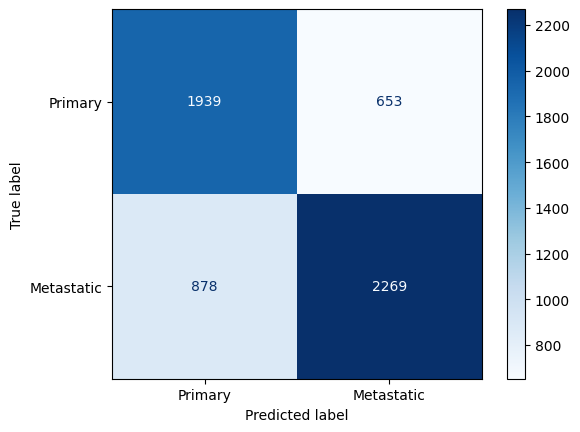

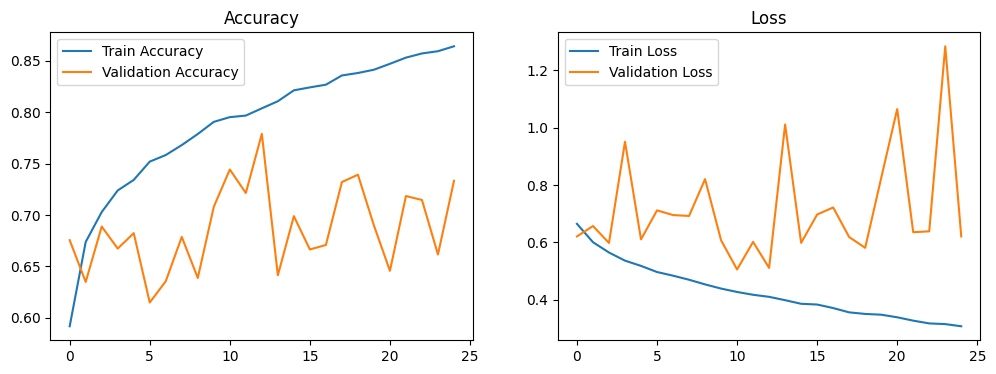

In [22]:
model.summary()

# Evaluate the model
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Classification metrics
print("Classification Report:\n", classification_report(y_true_classes, y_pred_classes))

# Confusion Matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Primary", "Metastatic"])
disp.plot(cmap=plt.cm.Blues)
plt.show()

# Training vs validation plots
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss')
plt.show()


**10. Grad-CAM Visualization**

The Grad-CAM technique is used to visualize the regions of the image that the ViT model focuses on for classification.



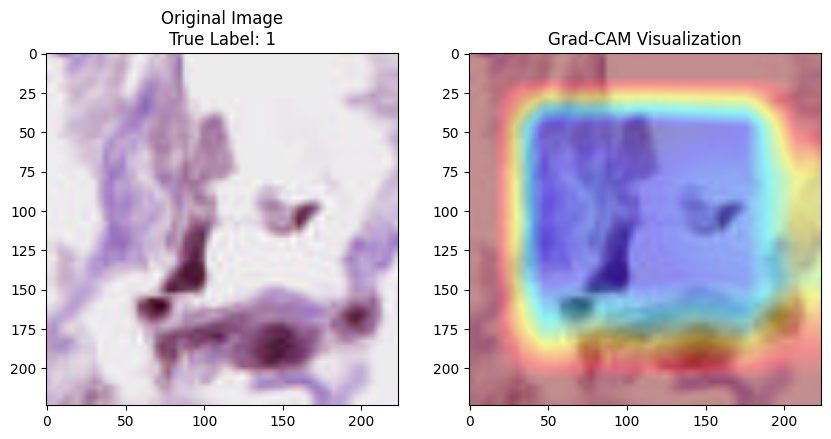

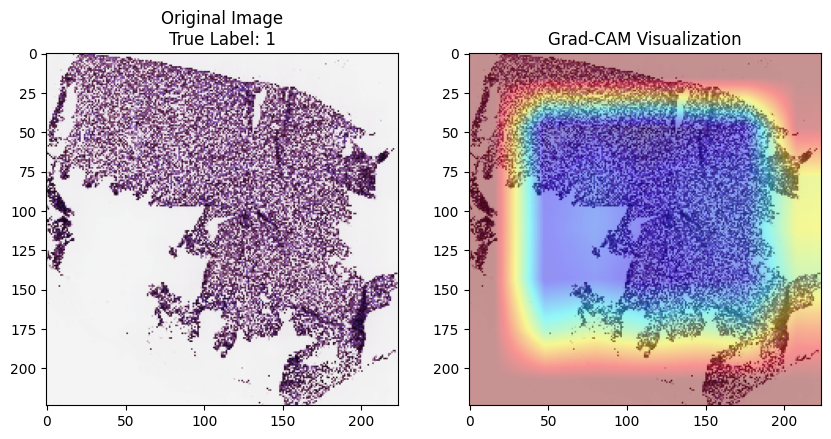

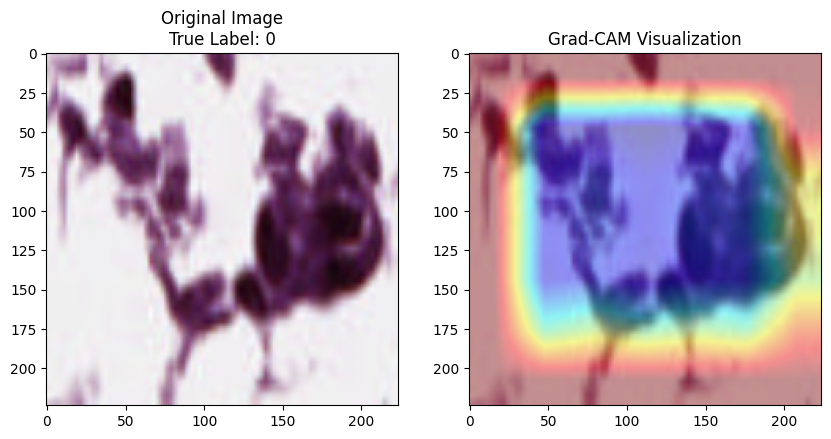

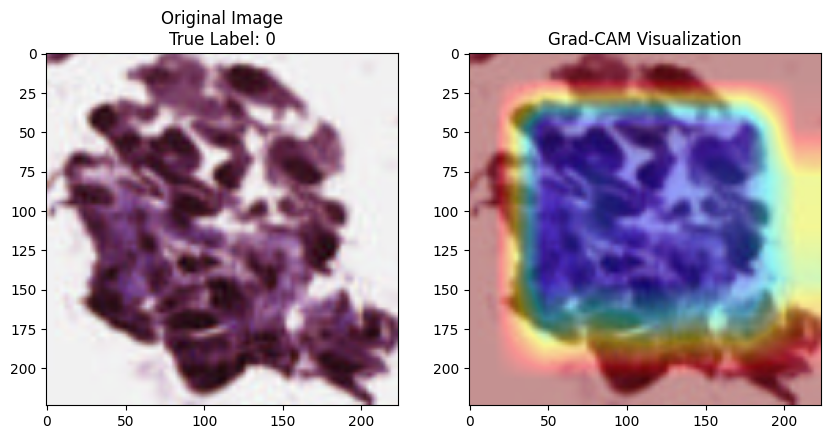

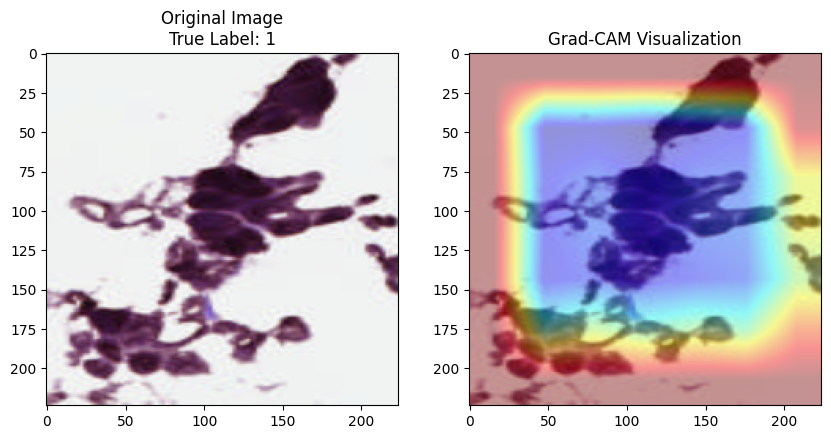

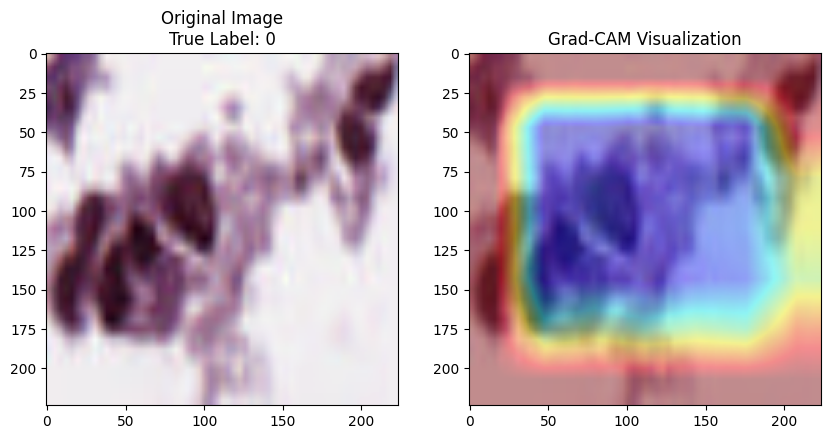

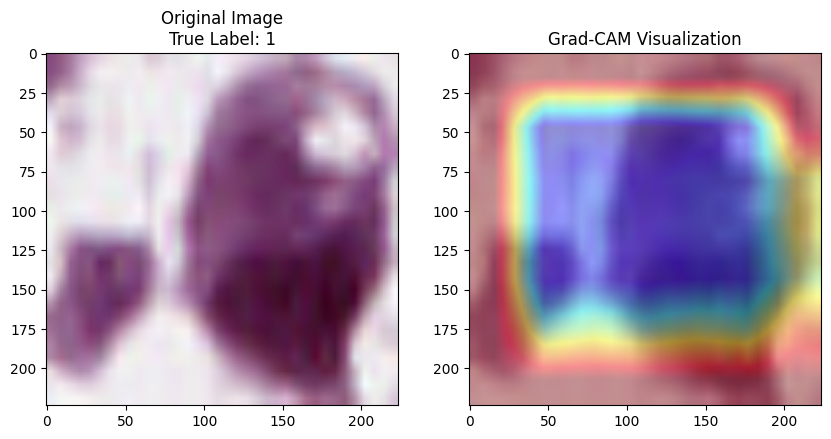

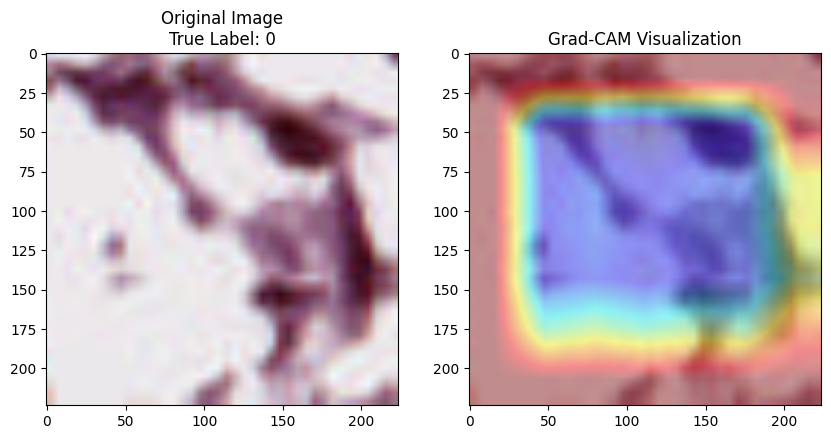

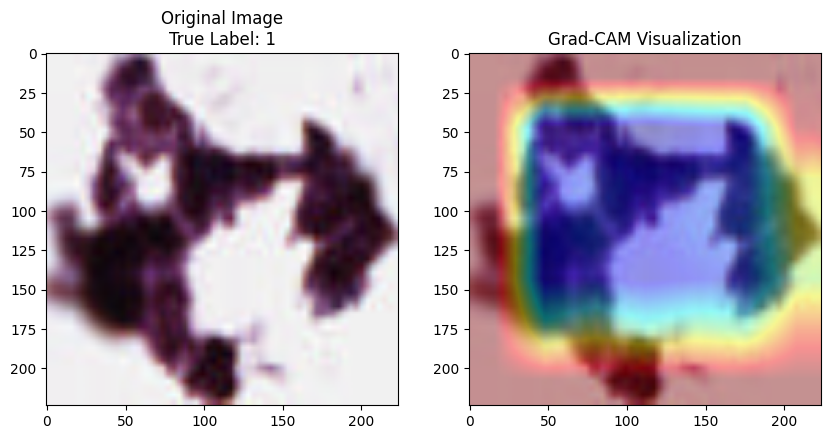

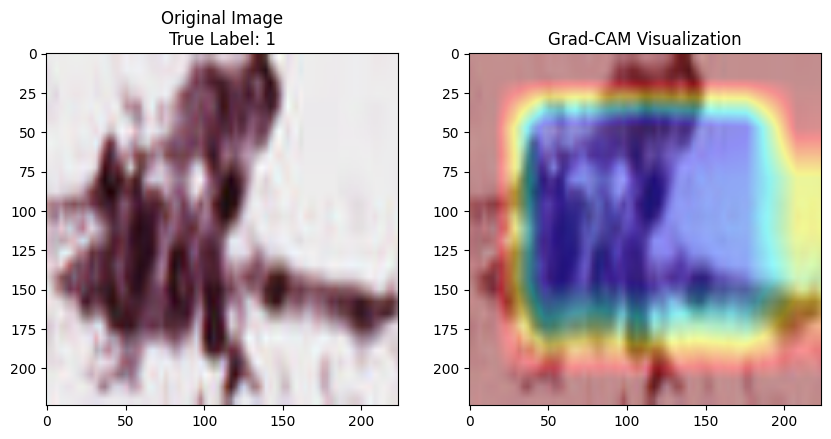

In [26]:
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import array_to_img

def get_gradcam_heatmap(model, img_array, last_conv_layer_name, pred_index=None):

    grad_model = Model(
        inputs=model.inputs,
        outputs=[model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]

    # Compute the gradient of the top predicted class
    grads = tape.gradient(class_channel, conv_outputs)

    # Pool the gradients
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # Multiply the pooled gradients with the convolutional outputs
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # Normalize the heatmap
    heatmap = np.maximum(heatmap, 0) / np.max(heatmap)
    return heatmap

def overlay_gradcam(image, heatmap, alpha=0.4):

    heatmap = cv2.resize(heatmap, (image.shape[1], image.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    overlayed_image = cv2.addWeighted(heatmap, alpha, image, 1 - alpha, 0)
    return overlayed_image

# Visualize Grad-CAM for a few test images
last_conv_layer_name = 'top_conv'  # Update this with the correct name of the last conv layer
sample_images = X_test[:10]  # Select the first 5 test images for visualization
sample_labels = np.argmax(y_test[:10], axis=1)

for i, img in enumerate(sample_images):
    img_array = np.expand_dims(img / 255.0, axis=0)  # Normalize and add batch dimension
    heatmap = get_gradcam_heatmap(model, img_array, last_conv_layer_name)

    overlayed_image = overlay_gradcam(np.uint8(img), heatmap)

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(array_to_img(img), cmap='gray')
    plt.title(f"Original Image\nTrue Label: {sample_labels[i]}")

    plt.subplot(1, 2, 2)
    plt.imshow(overlayed_image)
    plt.title("Grad-CAM Visualization")
    plt.show()
